In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow 

In [2]:
dataset_path = "../input/brain-tumor-images-with-masks/Brain Images with tumor masks/"

In [3]:
image_path = os.path.join(dataset_path,"yes/")
mask_path  = os.path.join(dataset_path,"masks/")
dataset = pd.read_csv(dataset_path + "train_data.csv")

In [4]:
dataset.head()

,Image,Mask
0,Y1.jpg,mask_Y1.jpg
1,Y10.jpg,mask_Y10.jpg
2,Y100.JPG,mask_Y100.JPG
3,Y101.jpg,mask_Y101.jpg
4,Y102.jpg,mask_Y102.jpg


# **Trying out Image Processing techinques to get mask**

In [5]:
def get_image_mask(img_name):
    img = cv2.imread(img_name)
    gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    plt.figure(figsize=(10,8))
    plt.subplot(141)
    plt.imshow(gray_img,"gray")
    
    ret, thresh = cv2.threshold(gray_img,0,255,cv2.THRESH_OTSU)
    plt.subplot(142)
    plt.imshow(thresh,"gray")
    
    ret, markers = cv2.connectedComponents(thresh)
    marker_area = [np.sum(markers==m) for m in range(np.max(markers)) if m!=0]
    largest_component = np.argmax(marker_area)+1  
    brain_mask = markers==largest_component
    
    brain_out = img.copy()
    brain_out[brain_mask==False] = (0,0,0)
    
    brain_out_gray = cv2.cvtColor(brain_out,cv2.COLOR_BGR2GRAY)
    plt.subplot(143)
    plt.imshow(brain_out_gray,"gray")
    
    
    blurred = cv2.blur(brain_out_gray,(5,5))
    ret, thresh_mask = cv2.threshold(blurred,170,255,cv2.THRESH_BINARY)
    plt.subplot(144)
    plt.imshow(thresh_mask,cmap="gray")
    plt.show()
    
    return thresh_mask

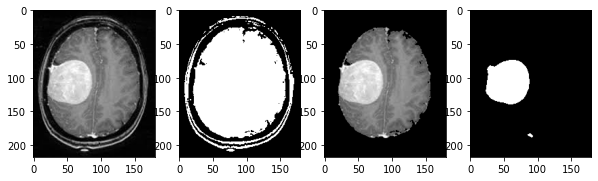

In [6]:
image = image_path + dataset.iloc[0][0]
mask = get_image_mask(image)

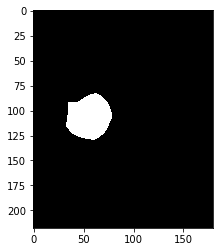

In [7]:
#extra processing if needed
kernel = np.ones((5,5),np.uint8)
mask_eroded = cv2.erode(mask,kernel,iterations = 4)
plt.imshow(mask_eroded,cmap='gray')

# **Visualizing Images and Masks**

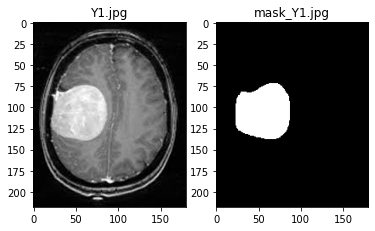

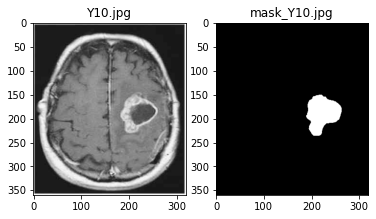

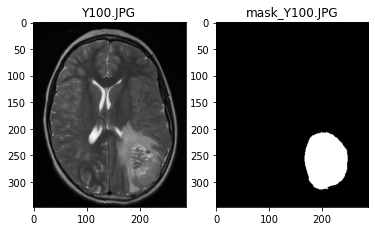

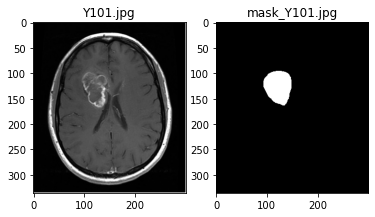

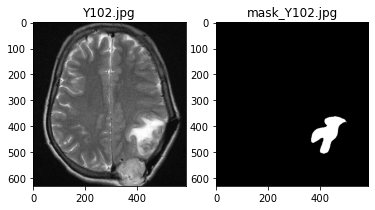

In [8]:
#processing masks form Imagebox
plt.figure()
for i in range(len(dataset.head())):
    image,mask = dataset.iloc[i]
    plt.subplot(121)
    img = cv2.imread(image_path + image)
    plt.imshow(img)
    plt.title(image)
    plt.subplot(122)
    mask_img = cv2.imread(mask_path +  mask)
    plt.imshow(mask_img)
    plt.title(mask)
    plt.show()

# **Data Split and Generator**

In [9]:
#Preparing Train and Validation set
from sklearn.model_selection import train_test_split
total = len(dataset)
test_split = 0.2
train, test = train_test_split(dataset,test_size = test_split,random_state = 50)

In [10]:
height = 256
width = 256
channels = 3
batch_size = 32

In [11]:
import sys
from skimage.transform import resize
from tqdm import tqdm
def data_generator(dataset,image_path,mask_path,height,width):
    
    X_train = np.zeros((len(dataset),height,width,3),dtype = np.uint8)
    y_train = np.zeros((len(dataset),height,width,1),dtype = np.uint8)
    
    sys.stdout.flush()
    
    for i in tqdm(range(len(dataset)),total=len(dataset)):
        image = cv2.imread(image_path + dataset.iloc[i][0])
        img_resized = resize(image,(height,width),mode='constant',preserve_range=True)
        X_train[i] = img_resized
        
        mask = cv2.imread(mask_path + dataset.iloc[i][1])[:,:,:1]
        mask_resized = resize(mask,(height,width),mode='constant',preserve_range=True)
        y_train[i] = mask_resized
        
    return X_train,y_train

In [12]:
X_train,y_train = data_generator(train,image_path,mask_path,height,width)

100%|██████████| 119/119 [00:05<00:00, 22.51it/s]


In [13]:
y_train = y_train / 255

## **Metrics and Loss**

In [14]:
def dice_coef(y_true,y_pred,epsilon=0.001):
  y_true_sum  = K.sum(y_true)
  y_pred_sum  = K.sum(y_pred)
  intersection = K.sum(y_true * y_pred)
  return ((2 * intersection + epsilon)/(y_true_sum + y_pred_sum + epsilon))

def dice_coef_loss(y_true,y_pred):
    return 1 - dice_coef(y_true,y_pred)

# **Model Definition**

In [15]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, concatenate
from tensorflow.keras.layers import Activation, BatchNormalization
import tensorflow.keras.backend as K

In [16]:
def unet(input_size=(256,256,3)):
    
    inputs = Input(input_size)
    x = Lambda(lambda x: x / 255)(inputs)
    
    #Contracting Path
    down_block_0_layer_0 = Conv2D(16,kernel_size=(3,3),padding="same")(x)
    down_block_0_layer_0 = Activation("relu")(down_block_0_layer_0)
    down_block_0_layer_1 = Conv2D(16,kernel_size=(3,3),padding='same')(down_block_0_layer_0)
    down_block_0_layer_1 = BatchNormalization(axis=3)(down_block_0_layer_1)
    down_block_0_layer_1 = Activation("relu")(down_block_0_layer_1)
    down_block_0_pool = MaxPool2D((2,2),strides=(2,2))(down_block_0_layer_1)
    
    down_block_1_layer_0 = Conv2D(32,kernel_size=(3,3),padding="same")(down_block_0_pool)
    down_block_1_layer_0 = Activation("relu")(down_block_1_layer_0)
    down_block_1_layer_1 = Conv2D(32,kernel_size=(3,3),padding='same')(down_block_1_layer_0)
    down_block_1_layer_1 = BatchNormalization(axis=3)(down_block_1_layer_1)
    down_block_1_layer_1 = Activation("relu")(down_block_1_layer_1)
    down_block_1_pool = MaxPool2D((2,2),strides=(2,2))(down_block_1_layer_1)
    
    down_block_2_layer_0 = Conv2D(64,kernel_size=(3,3),padding="same")(down_block_1_pool)
    down_block_2_layer_0 = Activation("relu")(down_block_2_layer_0)
    down_block_2_layer_1 = Conv2D(64,kernel_size=(3,3),padding='same')(down_block_2_layer_0)
    down_block_2_layer_1 = BatchNormalization(axis=3)(down_block_2_layer_1)
    down_block_2_layer_1 = Activation("relu")(down_block_2_layer_1)
    down_block_2_pool = MaxPool2D((2,2),strides=(2,2))(down_block_2_layer_1)
    
    down_block_3_layer_0 = Conv2D(128,kernel_size=(3,3),padding="same")(down_block_2_pool)
    down_block_3_layer_0 = Activation("relu")(down_block_3_layer_0)
    down_block_3_layer_1 = Conv2D(128,kernel_size=(3,3),padding='same')(down_block_3_layer_0)
    down_block_3_layer_1 = BatchNormalization(axis=3)(down_block_3_layer_1)
    down_block_3_layer_1 = Activation("relu")(down_block_3_layer_1)
    down_block_3_pool = MaxPool2D((2,2),strides=(2,2))(down_block_3_layer_1)
    
    down_block_4_layer_0 = Conv2D(256,kernel_size=(3,3),padding="same")(down_block_3_pool)
    down_block_4_layer_0 = Activation("relu")(down_block_4_layer_0)
    down_block_4_layer_1 = Conv2D(256,kernel_size=(3,3),padding='same')(down_block_4_layer_0)
    down_block_4_layer_1 = BatchNormalization(axis=3)(down_block_4_layer_1)
    down_block_4_layer_1 = Activation("relu")(down_block_4_layer_1)
    
    #Expanding Path
    up_block_0_upsample =  UpSampling2D((2,2))(down_block_4_layer_1)
    concat_block_0 =  concatenate([up_block_0_upsample,down_block_3_layer_1],axis=3)
    up_block_0_layer_0 = Conv2D(128,kernel_size=(3,3),padding="same")(concat_block_0)
    up_block_0_layer_0 = Activation("relu")(up_block_0_layer_0)
    up_block_0_layer_1 = Conv2D(128,kernel_size=(3,3),padding='same')(up_block_0_layer_0)
    up_block_0_layer_1 = BatchNormalization(axis=3)(up_block_0_layer_1)
    up_block_0_layer_1 = Activation("relu")(up_block_0_layer_1)
    
    up_block_1_upsample =  UpSampling2D((2,2))(up_block_0_layer_1)
    concat_block_1 =  concatenate([up_block_1_upsample,down_block_2_layer_1],axis=3)
    up_block_1_layer_0 = Conv2D(64,kernel_size=(3,3),padding="same")(concat_block_1)
    up_block_1_layer_0 = Activation("relu")(up_block_1_layer_0)
    up_block_1_layer_1 = Conv2D(64,kernel_size=(3,3),padding='same')(up_block_1_layer_0)
    up_block_1_layer_1 = BatchNormalization(axis=3)(up_block_1_layer_1)
    up_block_1_layer_1 = Activation("relu")(up_block_1_layer_1)
    
    up_block_2_upsample =  UpSampling2D((2,2))(up_block_1_layer_1)
    concat_block_2 =  concatenate([up_block_2_upsample,down_block_1_layer_1],axis=3)
    up_block_2_layer_0 = Conv2D(32,kernel_size=(3,3),padding="same")(concat_block_2)
    up_block_2_layer_0 = Activation("relu")(up_block_2_layer_0)
    up_block_2_layer_1 = Conv2D(32,kernel_size=(3,3),padding='same')(up_block_2_layer_0)
    up_block_2_layer_1 = BatchNormalization(axis=3)(up_block_2_layer_1)
    up_block_2_layer_1 = Activation("relu")(up_block_2_layer_1)
    
    up_block_3_upsample =  UpSampling2D((2,2))(up_block_2_layer_1)
    concat_block_3 =  concatenate([up_block_3_upsample,down_block_0_layer_1],axis=3)
    up_block_3_layer_0 = Conv2D(16,kernel_size=(3,3),padding="same")(concat_block_3)
    up_block_3_layer_0 = Activation("relu")(up_block_3_layer_0)
    up_block_3_layer_1 = Conv2D(16,kernel_size=(3,3),padding='same')(up_block_3_layer_0)
    up_block_3_layer_1 = BatchNormalization(axis=3)(up_block_3_layer_1)
    up_block_3_layer_1 = Activation("relu")(up_block_3_layer_1)
        

    outputs = Conv2D(1,(1,1),activation="sigmoid")(up_block_3_layer_1)
    
    return Model(inputs = [inputs], outputs = [outputs])

In [17]:
model = unet(input_size=(height,width,channels))
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           conv2d[0][0]                     
_______________________________________________________________________________________

# **Model Training**

In [18]:
epochs = 120
steps_per_epoch = len(train) // batch_size
batch_size = 16
learning_rate = 1e-4

In [19]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [20]:
model_path = "unet_model.h5"

checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

decay_rate = learning_rate / epochs
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)

In [21]:
model.compile(optimizer=opt,loss=dice_coef_loss,metrics=[dice_coef,'binary_accuracy'])
results = model.fit(X_train, y_train, validation_split=0.1,batch_size=batch_size, epochs=epochs,callbacks=[checkpoint])

Epoch 1/120
7/7 [==============================] - ETA: 0s - loss: 0.8804 - dice_coef: 0.1205 - binary_accuracy: 0.4768
Epoch 00001: val_loss improved from inf to 0.91199, saving model to unet_model.h5
7/7 [==============================] - 2s 309ms/step - loss: 0.8804 - dice_coef: 0.1205 - binary_accuracy: 0.4768 - val_loss: 0.9120 - val_dice_coef: 0.0880 - val_binary_accuracy: 0.7627
Epoch 2/120
7/7 [==============================] - ETA: 0s - loss: 0.8346 - dice_coef: 0.1672 - binary_accuracy: 0.6711
Epoch 00002: val_loss did not improve from 0.91199
7/7 [==============================] - 1s 87ms/step - loss: 0.8346 - dice_coef: 0.1672 - binary_accuracy: 0.6711 - val_loss: 0.9120 - val_dice_coef: 0.0880 - val_binary_accuracy: 0.9037
Epoch 3/120
7/7 [==============================] - ETA: 0s - loss: 0.8082 - dice_coef: 0.1912 - binary_accuracy: 0.7599
Epoch 00003: val_loss did not improve from 0.91199
7/7 [==============================] - 1s 86ms/step - loss: 0.8082 - dice_coef: 0.1

# **Training Results**

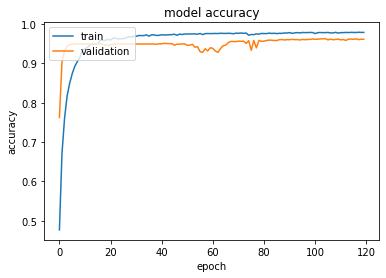

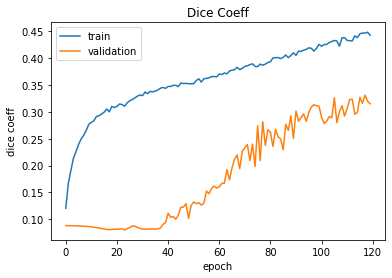

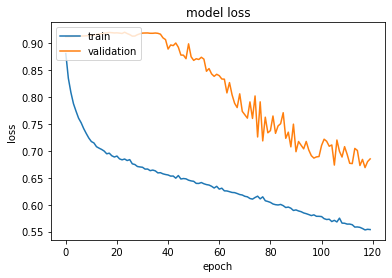

In [22]:
    plt.plot(results.history['binary_accuracy'])
    plt.plot(results.history['val_binary_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    
    plt.plot(results.history['dice_coef'])
    plt.plot(results.history['val_dice_coef'])
    plt.title('Dice Coeff')
    plt.ylabel('dice coeff')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    # "Loss"
    plt.plot(results.history['loss'])
    plt.plot(results.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [23]:
image,mask = test.iloc[2]
pred_img = cv2.imread(image_path + image)
img_resized = resize(pred_img, (height, width), mode='constant', preserve_range=True)
img_test = img_resized.reshape((1,height,width,channels)).astype(np.uint8)

img_mask = cv2.imread(mask_path + mask)
img_resized = resize(img_mask, (height, width), mode='constant', preserve_range=True)
mask_org = img_resized.reshape((1,height,width,channels)).astype(np.uint8)

In [24]:
model_pred = model.predict(img_test)
model_pred = (model_pred > 0.5).astype(np.uint8)

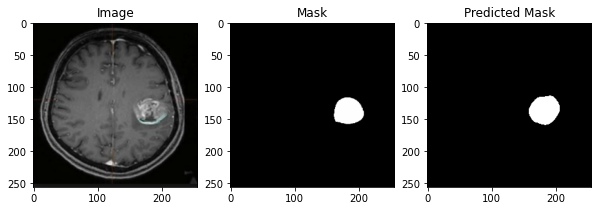

In [25]:
plt.figure(figsize=(10,5))
plt.subplot(131)
plt.imshow(img_test.squeeze())
plt.title("Image")
plt.subplot(132)
plt.imshow(mask_org.squeeze(),cmap='gray')
plt.title('Mask')
plt.subplot(133)
plt.imshow(model_pred.squeeze(),cmap='gray')
plt.title('Predicted Mask')
plt.show()

# **Model Testing**

In [26]:
from tensorflow.keras.models import load_model
model = load_model("unet_model.h5",custom_objects={'dice_coef_loss':dice_coef_loss,'dice_coef':dice_coef})

In [27]:
X_test,y_test = data_generator(test,image_path,mask_path,height,width)
y_test = y_test / 255

100%|██████████| 30/30 [00:01<00:00, 18.33it/s]


In [28]:
results = model.evaluate(X_test,y_test,steps=len(X_test)/batch_size)
print('Dice Loss: ',results[0])
print('Dice coeff: ',results[1])
print('Accuracy: ',results[2])

2/1 [================================] - 0s 141ms/step - loss: 0.6970 - dice_coef: 0.3060 - binary_accuracy: 0.9612
Dice Loss:  0.6969918012619019
Dice coeff:  0.30596455931663513
Accuracy:  0.9611765742301941


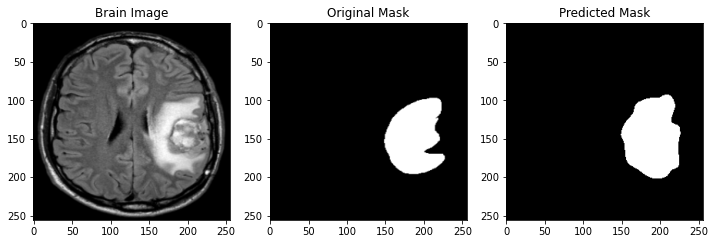

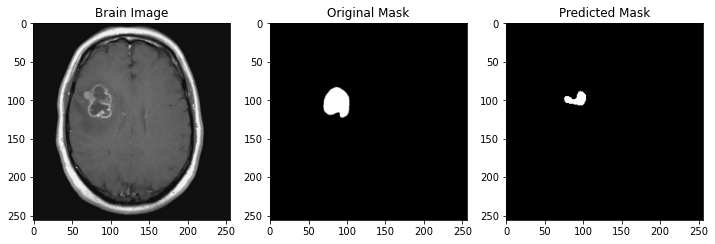

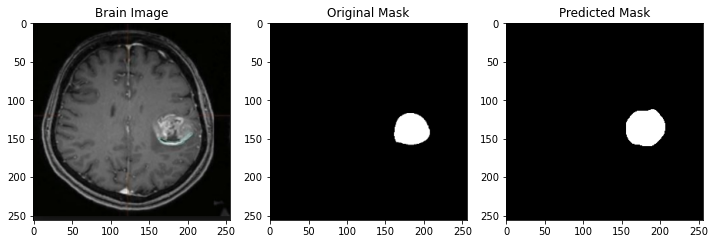

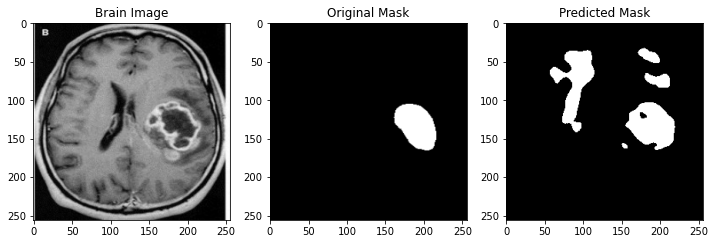

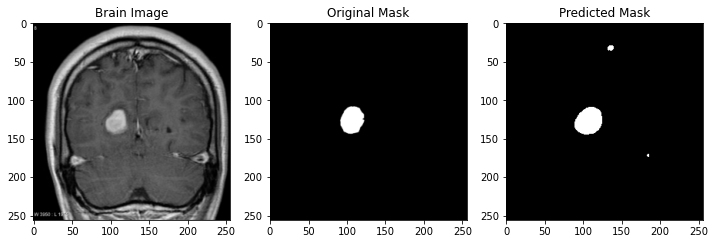

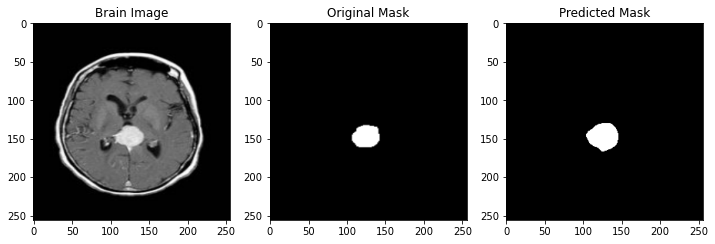

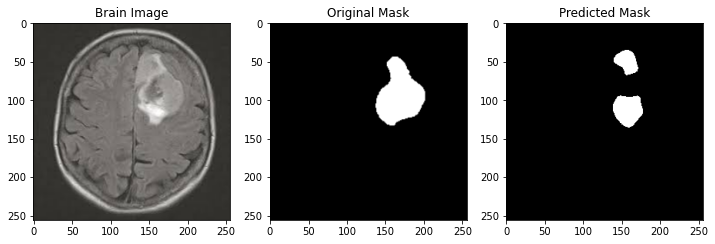

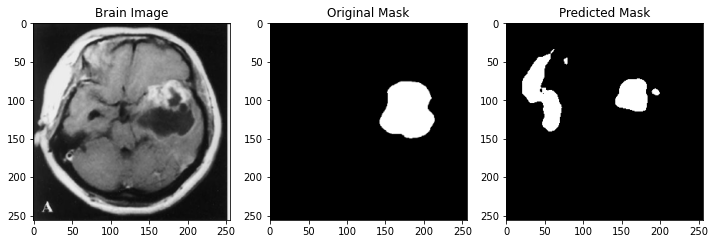

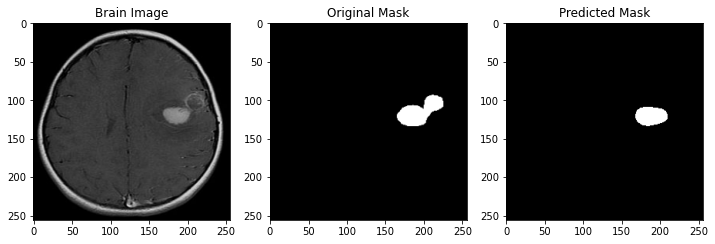

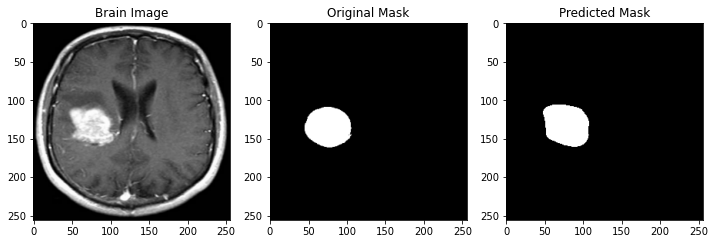

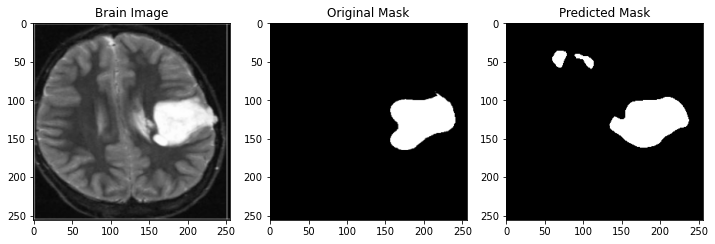

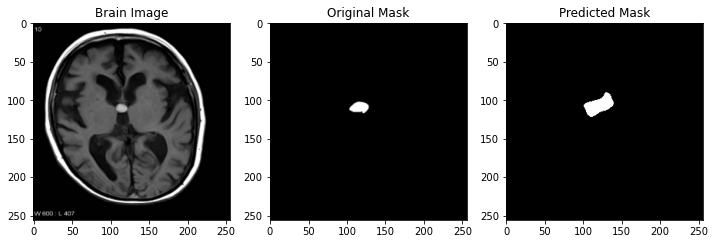

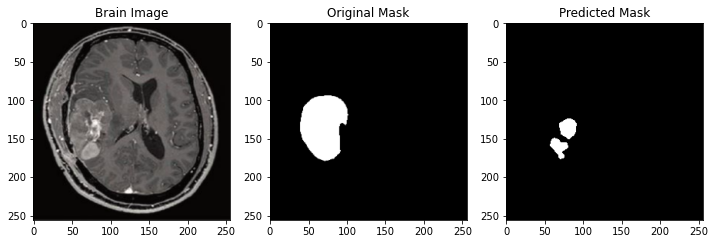

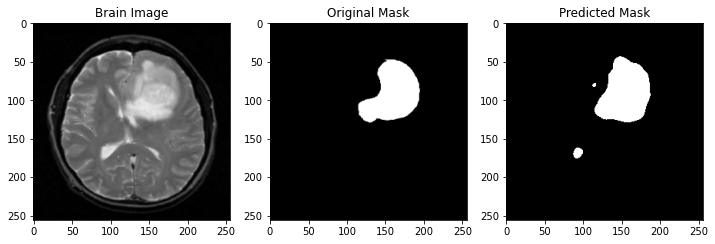

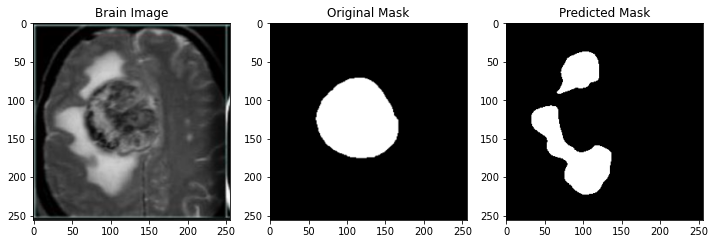

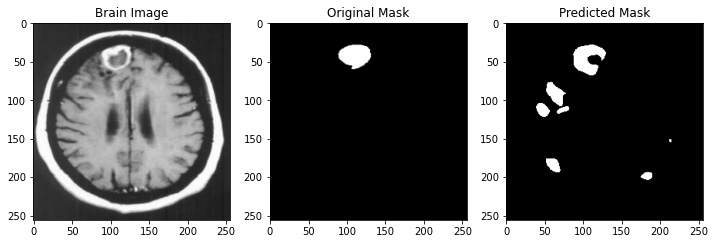

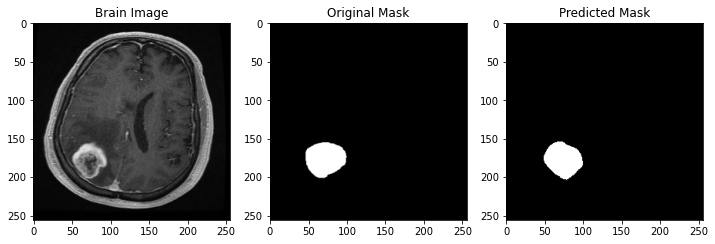

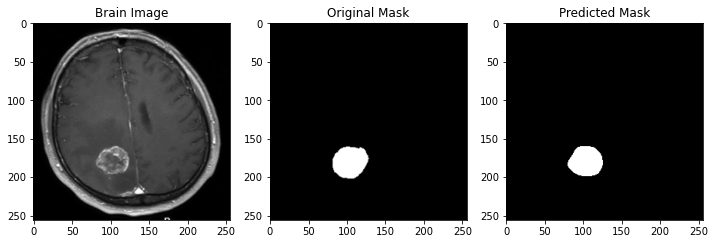

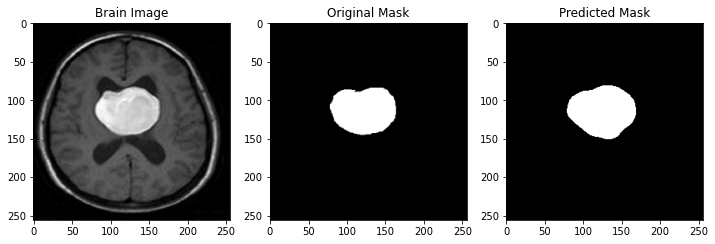

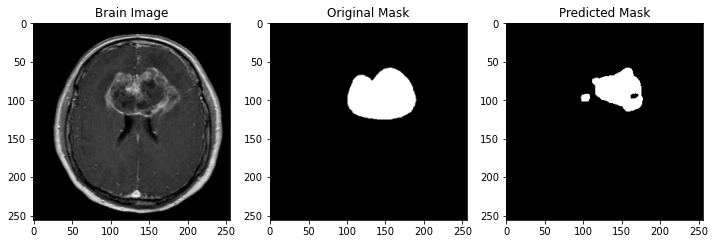

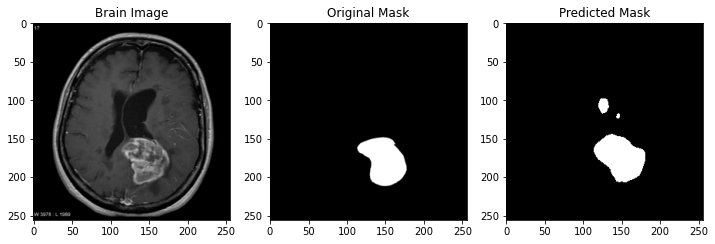

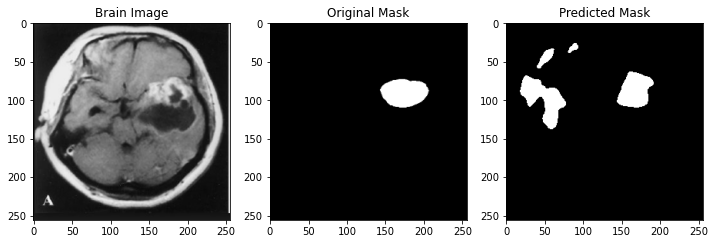

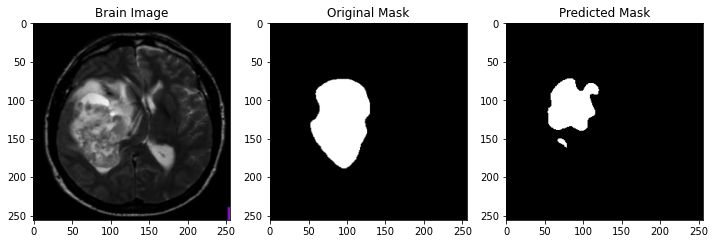

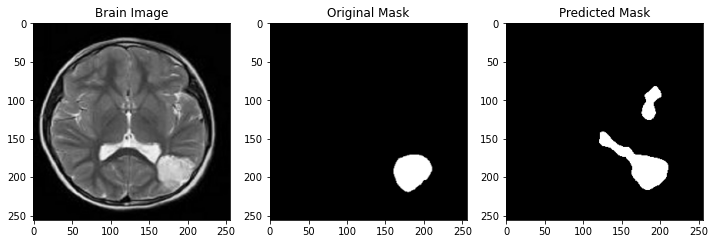

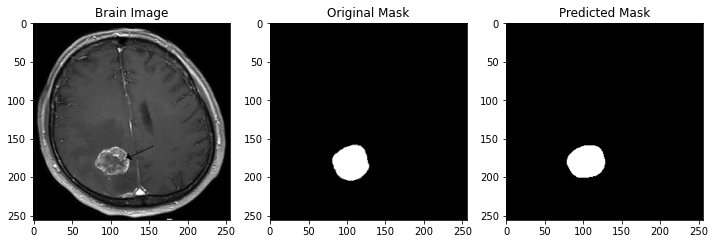

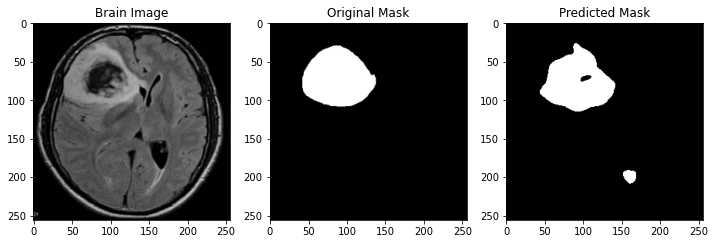

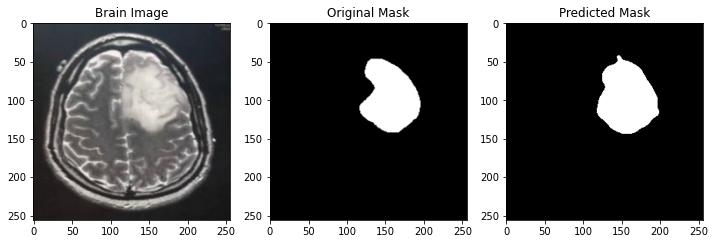

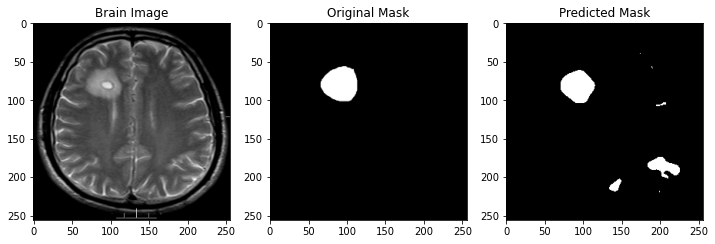

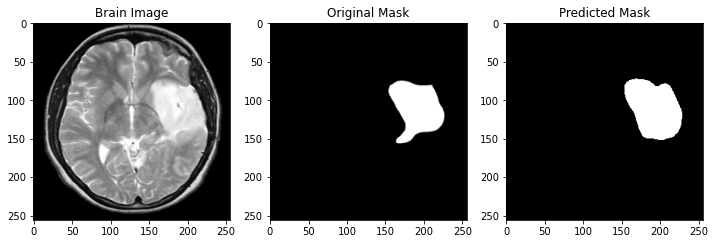

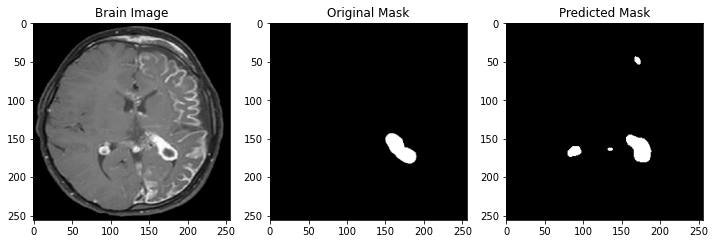

In [29]:
for image,mask in zip(X_test,y_test):
    img = image.reshape((1,height,width,channels)).astype(np.uint8)
    pred_mask = model.predict(img)
    pred_mask = (pred_mask > 0.5).astype(np.uint8)
    
    plt.figure(figsize=(12,12))
    plt.subplot(131)
    plt.imshow(image)
    plt.title("Brain Image")
    plt.subplot(132)
    plt.imshow(mask.squeeze(),cmap='gray')
    plt.title("Original Mask")
    plt.subplot(133)
    plt.imshow(pred_mask.squeeze(),cmap='gray')
    plt.title('Predicted Mask')
    plt.show()